In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras import layers
from keras.layers import *
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [2]:
ck_data = h5py.File('./CK_data.h5', 'r', driver='core')

In [3]:
X_data = np.expand_dims(np.asarray(ck_data['data_pixel']), axis=-1)

In [4]:
Y_data = np.asarray(ck_data['data_label'])

In [5]:
Y_data = to_categorical(Y_data)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2,random_state=0)

In [7]:
num_train = X_train.shape[0]

In [8]:
num_val = X_test.shape[0]

In [9]:
print('Training: ',X_train.shape)

Training:  (784, 48, 48, 1)


In [10]:
print('Validation: ',X_test.shape)

Validation:  (197, 48, 48, 1)


In [11]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D

In [12]:
from keras.models import Sequential

In [13]:
def get_nn_model():
    model = Sequential()
    model.add(Flatten(input_shape=(48,48,1)))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [14]:
def get_cnn_model():
    model = Sequential()

    model.add(Convolution2D(64, (3, 1), padding='same', input_shape=(48,48,1)))
    model.add(Convolution2D(64, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 1), padding='same'))
    model.add(Convolution2D(128, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 1), padding='same'))
    model.add(Convolution2D(256, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 1), padding='same'))
    model.add(Convolution2D(512, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [15]:
cnn_model = get_cnn_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
nn_model = get_nn_model()

In [17]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       24704     
__________

In [18]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1180160   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
__________

In [19]:
from keras.preprocessing.image import ImageDataGenerator 

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [21]:
from keras import backend as K

In [22]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [23]:
def train_cnn_model(model):
    filepath='../opt/ck-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    test_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [24]:
def train_nn_model(model):
    filepath='../opt/ck-nn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    test_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [25]:
history, cnn_model = train_cnn_model(cnn_model)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
25/24 [==============================] - 4s 160ms/step - loss: 1.7477 - fbeta: 0.2010 - acc: 0.3774 - val_loss: 2.0287 - val_fbeta: 0.4315 - val_acc: 0.4721

Epoch 00001: saving model to ../opt/ck-cnn/Model.01-0.4721.hdf5

Epoch 00001: saving model to ../opt/ck-cnn/Model.01-0.4721.hdf5
Epoch 2/200
25/24 [==============================] - 1s 23ms/step - loss: 1.0215 - fbeta: 0.5237 - acc: 0.6425 - val_loss: 2.4463 - val_fbeta: 0.4569 - val_acc: 0.4569

Epoch 00002: saving model to ../opt/ck-cnn/Model.02-0.4569.hdf5

Epoch 00002: saving model to ../opt/ck-cnn/Model.02-0.4569.hdf5
Epoch 3/200
25/24 [==============================] - 1s 22ms/step - loss: 0.7148 - fbeta: 0.6500 - acc: 0.7175 - val_loss: 2.5230 - val_fbeta: 0.4670 - val_acc: 0.4772

Epoch 00003: saving model to ../opt/ck-cnn/Model.03-0.4772.hdf5

Epoch 00003: saving model to ../opt/ck-cnn/Model.03-0.4772.hdf5
Epoch 4/200
25/24 [==============================] - 1s 2


Epoch 00027: saving model to ../opt/ck-cnn/Model.27-0.9492.hdf5

Epoch 00027: saving model to ../opt/ck-cnn/Model.27-0.9492.hdf5
Epoch 28/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0744 - fbeta: 0.9738 - acc: 0.9738 - val_loss: 0.1122 - val_fbeta: 0.9594 - val_acc: 0.9594

Epoch 00028: saving model to ../opt/ck-cnn/Model.28-0.9594.hdf5

Epoch 00028: saving model to ../opt/ck-cnn/Model.28-0.9594.hdf5
Epoch 29/200
25/24 [==============================] - 1s 22ms/step - loss: 0.1168 - fbeta: 0.9612 - acc: 0.9625 - val_loss: 1.2773 - val_fbeta: 0.6244 - val_acc: 0.6396

Epoch 00029: saving model to ../opt/ck-cnn/Model.29-0.6396.hdf5

Epoch 00029: saving model to ../opt/ck-cnn/Model.29-0.6396.hdf5
Epoch 30/200
25/24 [==============================] - 1s 21ms/step - loss: 0.0620 - fbeta: 0.9750 - acc: 0.9763 - val_loss: 0.2662 - val_fbeta: 0.8985 - val_acc: 0.9086

Epoch 00030: saving model to ../opt/ck-cnn/Model.30-0.9086.hdf5

Epoch 00030: saving model to ../opt/c

Epoch 55/200
25/24 [==============================] - 1s 24ms/step - loss: 0.0053 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0159 - val_fbeta: 0.9898 - val_acc: 0.9898

Epoch 00055: saving model to ../opt/ck-cnn/Model.55-0.9898.hdf5

Epoch 00055: saving model to ../opt/ck-cnn/Model.55-0.9898.hdf5
Epoch 56/200
25/24 [==============================] - 1s 24ms/step - loss: 0.0088 - fbeta: 0.9987 - acc: 0.9987 - val_loss: 0.0101 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00056: saving model to ../opt/ck-cnn/Model.56-0.9949.hdf5

Epoch 00056: saving model to ../opt/ck-cnn/Model.56-0.9949.hdf5
Epoch 57/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0304 - fbeta: 0.9863 - acc: 0.9863 - val_loss: 0.0182 - val_fbeta: 0.9898 - val_acc: 0.9898

Epoch 00057: saving model to ../opt/ck-cnn/Model.57-0.9898.hdf5

Epoch 00057: saving model to ../opt/ck-cnn/Model.57-0.9898.hdf5
Epoch 58/200
25/24 [==============================] - 1s 22ms/step - loss: 0.0093 - fbeta: 0.9975 - acc


Epoch 00082: saving model to ../opt/ck-cnn/Model.82-0.9949.hdf5

Epoch 00082: saving model to ../opt/ck-cnn/Model.82-0.9949.hdf5
Epoch 83/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0070 - fbeta: 0.9975 - acc: 0.9987 - val_loss: 0.0049 - val_fbeta: 1.0000 - val_acc: 1.0000

Epoch 00083: saving model to ../opt/ck-cnn/Model.83-1.0000.hdf5

Epoch 00083: saving model to ../opt/ck-cnn/Model.83-1.0000.hdf5
Epoch 84/200
25/24 [==============================] - 1s 22ms/step - loss: 0.0040 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0039 - val_fbeta: 1.0000 - val_acc: 1.0000

Epoch 00084: saving model to ../opt/ck-cnn/Model.84-1.0000.hdf5

Epoch 00084: saving model to ../opt/ck-cnn/Model.84-1.0000.hdf5
Epoch 85/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0032 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0068 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00085: saving model to ../opt/ck-cnn/Model.85-0.9949.hdf5

Epoch 00085: saving model to ../opt/c

25/24 [==============================] - 1s 24ms/step - loss: 0.0043 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0040 - val_fbeta: 1.0000 - val_acc: 1.0000

Epoch 00110: saving model to ../opt/ck-cnn/Model.110-1.0000.hdf5

Epoch 00110: saving model to ../opt/ck-cnn/Model.110-1.0000.hdf5
Epoch 111/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0058 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0074 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00111: saving model to ../opt/ck-cnn/Model.111-0.9949.hdf5

Epoch 00111: saving model to ../opt/ck-cnn/Model.111-0.9949.hdf5
Epoch 112/200
25/24 [==============================] - 1s 24ms/step - loss: 0.0173 - fbeta: 0.9938 - acc: 0.9938 - val_loss: 0.0076 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00112: saving model to ../opt/ck-cnn/Model.112-0.9949.hdf5

Epoch 00112: saving model to ../opt/ck-cnn/Model.112-0.9949.hdf5
Epoch 113/200
25/24 [==============================] - 1s 25ms/step - loss: 0.0058 - fbeta: 1.0000 - acc: 1.

25/24 [==============================] - 1s 24ms/step - loss: 0.0087 - fbeta: 0.9962 - acc: 0.9962 - val_loss: 0.0078 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00137: saving model to ../opt/ck-cnn/Model.137-0.9949.hdf5

Epoch 00137: saving model to ../opt/ck-cnn/Model.137-0.9949.hdf5
Epoch 138/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0139 - fbeta: 0.9962 - acc: 0.9962 - val_loss: 0.0053 - val_fbeta: 1.0000 - val_acc: 1.0000

Epoch 00138: saving model to ../opt/ck-cnn/Model.138-1.0000.hdf5

Epoch 00138: saving model to ../opt/ck-cnn/Model.138-1.0000.hdf5
Epoch 139/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0056 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0060 - val_fbeta: 1.0000 - val_acc: 1.0000

Epoch 00139: saving model to ../opt/ck-cnn/Model.139-1.0000.hdf5

Epoch 00139: saving model to ../opt/ck-cnn/Model.139-1.0000.hdf5
Epoch 140/200
25/24 [==============================] - 1s 25ms/step - loss: 0.0046 - fbeta: 1.0000 - acc: 1.

25/24 [==============================] - 1s 23ms/step - loss: 0.0122 - fbeta: 0.9962 - acc: 0.9962 - val_loss: 0.0083 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00164: saving model to ../opt/ck-cnn/Model.164-0.9949.hdf5

Epoch 00164: saving model to ../opt/ck-cnn/Model.164-0.9949.hdf5
Epoch 165/200
25/24 [==============================] - 1s 22ms/step - loss: 0.0099 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0088 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00165: saving model to ../opt/ck-cnn/Model.165-0.9949.hdf5

Epoch 00165: saving model to ../opt/ck-cnn/Model.165-0.9949.hdf5
Epoch 166/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0084 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0042 - val_fbeta: 1.0000 - val_acc: 1.0000

Epoch 00166: saving model to ../opt/ck-cnn/Model.166-1.0000.hdf5

Epoch 00166: saving model to ../opt/ck-cnn/Model.166-1.0000.hdf5
Epoch 167/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0072 - fbeta: 1.0000 - acc: 1.

25/24 [==============================] - 1s 23ms/step - loss: 0.0077 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0063 - val_fbeta: 1.0000 - val_acc: 1.0000

Epoch 00191: saving model to ../opt/ck-cnn/Model.191-1.0000.hdf5

Epoch 00191: saving model to ../opt/ck-cnn/Model.191-1.0000.hdf5
Epoch 192/200
25/24 [==============================] - 1s 22ms/step - loss: 0.0040 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0075 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00192: saving model to ../opt/ck-cnn/Model.192-0.9949.hdf5

Epoch 00192: saving model to ../opt/ck-cnn/Model.192-0.9949.hdf5
Epoch 193/200
25/24 [==============================] - 1s 23ms/step - loss: 0.0076 - fbeta: 0.9987 - acc: 0.9987 - val_loss: 0.0072 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00193: saving model to ../opt/ck-cnn/Model.193-0.9949.hdf5

Epoch 00193: saving model to ../opt/ck-cnn/Model.193-0.9949.hdf5
Epoch 194/200
25/24 [==============================] - 1s 21ms/step - loss: 0.0084 - fbeta: 0.9987 - acc: 0.

In [26]:
nn_history, nn_model = train_nn_model(nn_model)

Epoch 1/200
25/24 [==============================] - 1s 54ms/step - loss: 1.1619 - fbeta: 0.4361 - acc: 0.6061 - val_loss: 1.1943 - val_fbeta: 0.5076 - val_acc: 0.5888

Epoch 00001: saving model to ../opt/ck-nn/Model.01-0.5888.hdf5

Epoch 00001: saving model to ../opt/ck-nn/Model.01-0.5888.hdf5
Epoch 2/200
25/24 [==============================] - 0s 11ms/step - loss: 0.6281 - fbeta: 0.6862 - acc: 0.8049 - val_loss: 0.8705 - val_fbeta: 0.6345 - val_acc: 0.6802

Epoch 00002: saving model to ../opt/ck-nn/Model.02-0.6802.hdf5

Epoch 00002: saving model to ../opt/ck-nn/Model.02-0.6802.hdf5
Epoch 3/200
25/24 [==============================] - 0s 12ms/step - loss: 0.4290 - fbeta: 0.7887 - acc: 0.8687 - val_loss: 0.5999 - val_fbeta: 0.7766 - val_acc: 0.8274

Epoch 00003: saving model to ../opt/ck-nn/Model.03-0.8274.hdf5

Epoch 00003: saving model to ../opt/ck-nn/Model.03-0.8274.hdf5
Epoch 4/200
25/24 [==============================] - 0s 12ms/step - loss: 0.3442 - fbeta: 0.8525 - acc: 0.8838 -


Epoch 00028: saving model to ../opt/ck-nn/Model.28-0.7716.hdf5
Epoch 29/200
25/24 [==============================] - 0s 12ms/step - loss: 0.0621 - fbeta: 0.9800 - acc: 0.9837 - val_loss: 0.7014 - val_fbeta: 0.7919 - val_acc: 0.7970

Epoch 00029: saving model to ../opt/ck-nn/Model.29-0.7970.hdf5

Epoch 00029: saving model to ../opt/ck-nn/Model.29-0.7970.hdf5
Epoch 30/200
25/24 [==============================] - 0s 12ms/step - loss: 0.0514 - fbeta: 0.9825 - acc: 0.9825 - val_loss: 0.2764 - val_fbeta: 0.9188 - val_acc: 0.9239

Epoch 00030: saving model to ../opt/ck-nn/Model.30-0.9239.hdf5

Epoch 00030: saving model to ../opt/ck-nn/Model.30-0.9239.hdf5
Epoch 31/200
25/24 [==============================] - 0s 12ms/step - loss: 0.0664 - fbeta: 0.9725 - acc: 0.9750 - val_loss: 1.3156 - val_fbeta: 0.6853 - val_acc: 0.6853

Epoch 00031: saving model to ../opt/ck-nn/Model.31-0.6853.hdf5

Epoch 00031: saving model to ../opt/ck-nn/Model.31-0.6853.hdf5
Epoch 32/200
25/24 [=========================


Epoch 00056: saving model to ../opt/ck-nn/Model.56-0.9848.hdf5

Epoch 00056: saving model to ../opt/ck-nn/Model.56-0.9848.hdf5
Epoch 57/200
25/24 [==============================] - 0s 12ms/step - loss: 0.0189 - fbeta: 0.9925 - acc: 0.9975 - val_loss: 0.0398 - val_fbeta: 0.9848 - val_acc: 0.9848

Epoch 00057: saving model to ../opt/ck-nn/Model.57-0.9848.hdf5

Epoch 00057: saving model to ../opt/ck-nn/Model.57-0.9848.hdf5
Epoch 58/200
25/24 [==============================] - 0s 11ms/step - loss: 0.0121 - fbeta: 0.9987 - acc: 0.9987 - val_loss: 0.0259 - val_fbeta: 0.9848 - val_acc: 0.9848

Epoch 00058: saving model to ../opt/ck-nn/Model.58-0.9848.hdf5

Epoch 00058: saving model to ../opt/ck-nn/Model.58-0.9848.hdf5
Epoch 59/200
25/24 [==============================] - 0s 13ms/step - loss: 0.0200 - fbeta: 0.9950 - acc: 0.9950 - val_loss: 0.0369 - val_fbeta: 0.9848 - val_acc: 0.9848

Epoch 00059: saving model to ../opt/ck-nn/Model.59-0.9848.hdf5

Epoch 00059: saving model to ../opt/ck-nn/Mo

25/24 [==============================] - 0s 13ms/step - loss: 0.0060 - fbeta: 0.9987 - acc: 0.9987 - val_loss: 0.0272 - val_fbeta: 0.9848 - val_acc: 0.9848

Epoch 00084: saving model to ../opt/ck-nn/Model.84-0.9848.hdf5

Epoch 00084: saving model to ../opt/ck-nn/Model.84-0.9848.hdf5
Epoch 85/200
25/24 [==============================] - 0s 12ms/step - loss: 0.0083 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0160 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00085: saving model to ../opt/ck-nn/Model.85-0.9949.hdf5

Epoch 00085: saving model to ../opt/ck-nn/Model.85-0.9949.hdf5
Epoch 86/200
25/24 [==============================] - 0s 11ms/step - loss: 0.0082 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0182 - val_fbeta: 0.9898 - val_acc: 0.9898

Epoch 00086: saving model to ../opt/ck-nn/Model.86-0.9898.hdf5

Epoch 00086: saving model to ../opt/ck-nn/Model.86-0.9898.hdf5
Epoch 87/200
25/24 [==============================] - 0s 11ms/step - loss: 0.0034 - fbeta: 1.0000 - acc: 1.0000 - val_loss


Epoch 00111: saving model to ../opt/ck-nn/Model.111-0.9949.hdf5

Epoch 00111: saving model to ../opt/ck-nn/Model.111-0.9949.hdf5
Epoch 112/200
25/24 [==============================] - 0s 10ms/step - loss: 0.0064 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0111 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00112: saving model to ../opt/ck-nn/Model.112-0.9949.hdf5

Epoch 00112: saving model to ../opt/ck-nn/Model.112-0.9949.hdf5
Epoch 113/200
25/24 [==============================] - 0s 10ms/step - loss: 0.0056 - fbeta: 0.9987 - acc: 0.9987 - val_loss: 0.0141 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00113: saving model to ../opt/ck-nn/Model.113-0.9949.hdf5

Epoch 00113: saving model to ../opt/ck-nn/Model.113-0.9949.hdf5
Epoch 114/200
25/24 [==============================] - 0s 10ms/step - loss: 0.0054 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0116 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00114: saving model to ../opt/ck-nn/Model.114-0.9949.hdf5

Epoch 00114: saving model to ../op

Epoch 139/200
25/24 [==============================] - 0s 12ms/step - loss: 0.0063 - fbeta: 0.9987 - acc: 0.9987 - val_loss: 0.0112 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00139: saving model to ../opt/ck-nn/Model.139-0.9949.hdf5

Epoch 00139: saving model to ../opt/ck-nn/Model.139-0.9949.hdf5
Epoch 140/200
25/24 [==============================] - 0s 9ms/step - loss: 0.0046 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0146 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00140: saving model to ../opt/ck-nn/Model.140-0.9949.hdf5

Epoch 00140: saving model to ../opt/ck-nn/Model.140-0.9949.hdf5
Epoch 141/200
25/24 [==============================] - 0s 9ms/step - loss: 0.0070 - fbeta: 0.9975 - acc: 0.9987 - val_loss: 0.0127 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00141: saving model to ../opt/ck-nn/Model.141-0.9949.hdf5

Epoch 00141: saving model to ../opt/ck-nn/Model.141-0.9949.hdf5
Epoch 142/200
25/24 [==============================] - 0s 10ms/step - loss: 0.0083 - fbeta: 0.9987 - a

25/24 [==============================] - 0s 12ms/step - loss: 0.0046 - fbeta: 0.9987 - acc: 0.9987 - val_loss: 0.0149 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00166: saving model to ../opt/ck-nn/Model.166-0.9949.hdf5

Epoch 00166: saving model to ../opt/ck-nn/Model.166-0.9949.hdf5
Epoch 167/200
25/24 [==============================] - 0s 11ms/step - loss: 0.0098 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0132 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00167: saving model to ../opt/ck-nn/Model.167-0.9949.hdf5

Epoch 00167: saving model to ../opt/ck-nn/Model.167-0.9949.hdf5
Epoch 168/200
25/24 [==============================] - 0s 11ms/step - loss: 0.0106 - fbeta: 0.9962 - acc: 0.9975 - val_loss: 0.0135 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00168: saving model to ../opt/ck-nn/Model.168-0.9949.hdf5

Epoch 00168: saving model to ../opt/ck-nn/Model.168-0.9949.hdf5
Epoch 169/200
25/24 [==============================] - 0s 11ms/step - loss: 0.0065 - fbeta: 0.9987 - acc: 0.9987 -

25/24 [==============================] - 0s 11ms/step - loss: 0.0091 - fbeta: 0.9975 - acc: 0.9987 - val_loss: 0.0145 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00193: saving model to ../opt/ck-nn/Model.193-0.9949.hdf5

Epoch 00193: saving model to ../opt/ck-nn/Model.193-0.9949.hdf5
Epoch 194/200
25/24 [==============================] - 0s 11ms/step - loss: 0.0078 - fbeta: 0.9975 - acc: 0.9975 - val_loss: 0.0139 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00194: saving model to ../opt/ck-nn/Model.194-0.9949.hdf5

Epoch 00194: saving model to ../opt/ck-nn/Model.194-0.9949.hdf5
Epoch 195/200
25/24 [==============================] - 0s 12ms/step - loss: 0.0072 - fbeta: 1.0000 - acc: 1.0000 - val_loss: 0.0118 - val_fbeta: 0.9949 - val_acc: 0.9949

Epoch 00195: saving model to ../opt/ck-nn/Model.195-0.9949.hdf5

Epoch 00195: saving model to ../opt/ck-nn/Model.195-0.9949.hdf5
Epoch 196/200
25/24 [==============================] - 0s 13ms/step - loss: 0.0108 - fbeta: 0.9975 - acc: 0.9987 -

In [27]:
n_classes = Y_data.shape[1]

In [28]:
labels=range(n_classes)

In [29]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                        cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                        fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

6/6 [==============================] - 0s 36ms/step
Evaluation loss:  0.004030243493616581
Evaluation accuracy:  1.0


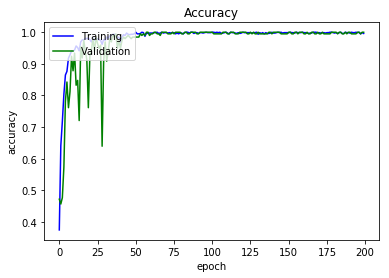

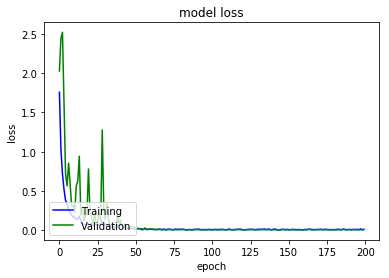

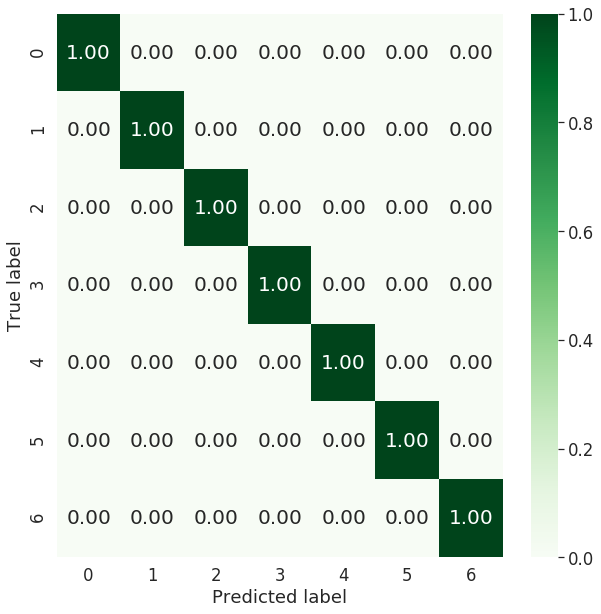

In [30]:
eval_model(history, cnn_model)

6/6 [==============================] - 0s 4ms/step
Evaluation loss:  0.011647302657365799
Evaluation accuracy:  0.9949238300323486


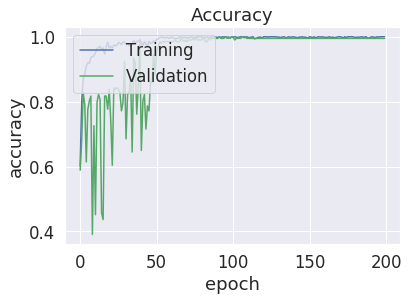

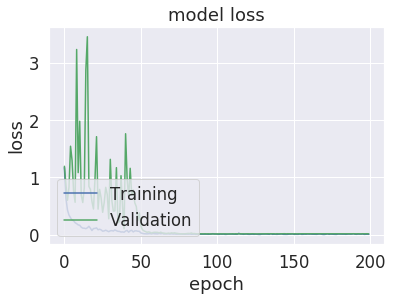

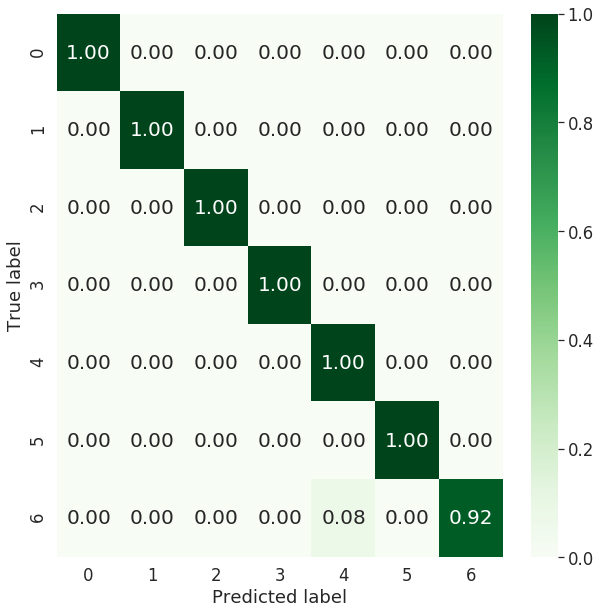

In [31]:
eval_model(nn_history, nn_model)